# Gaussian Density Filtering for predicting mid price raise in LOBs

## Data

stocks, 10000



In [24]:
%matplotlib inline
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from typing import Tuple
import numpy as np
import itertools

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from scipy.stats import norm

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

import warnings

from lob_data_utils import lob, db_result, roc_results

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True)

## Methodology

2 steps:

* normalization
* applying gdf

### Normalization

LOB is a list of orders. Each order consist of price and volume. To normalize LOB we use approach descibed below:

volume_norm = price * volume / sum(volumes)
price_norm = 1000 * (price - mid_price) / mid_price where mid_price is TODO

### Applying GDF



    def gdf_representation(buy_orders, sell_orders, gdf):
        buy_price, buy_volume = buy_orders
        sell_price, sell_volume = sell_orders
        buy_gdf_y = gdf[0] * norm.pdf(buy_price, loc=gdf[1], scale=gdf[2])
        sell_gdf_y = gdf[0] * norm.pdf(sell_price, loc=gdf[1], scale=gdf[2])
        return np.clip(buy_volume, 0.0, buy_gdf_y).sum() + np.clip(sell_volume, 0.0, sell_gdf_y).sum()

In [2]:
import plotly.offline as py
import plotly.graph_objs as go

df_9061 = pd.read_csv('data/9061.csv')
df_9061.head()

time = 0

orders = literal_eval(df_9061['bid'].iloc[time]) + literal_eval(df_9061['ask'].iloc[time])
mid_price = df_9061.iloc[time]['mid_price']
df_orders = pd.DataFrame([{'price': k, 'volume': v} for k, v in orders])
df_orders = df_orders.sort_values(by='price')

order_data = go.Bar(x=df_orders['price'], y=df_orders['volume'], name = 'orders', 
              marker = dict(color = 'rgb(0, 128, 0)', line = dict(color = 'rgb(0, 128, 0)', width = 1.5)), 
              opacity = 0.75)

data = go.Data([order_data])
layout = go.Layout(
    title = 'Orders',
    xaxis = dict(title='price'),
    yaxis = dict(title='volume'),
    showlegend = True,
    legend = dict(orientation="h"))

layout.update(
    shapes = [dict(
        type = 'line',
        xref = 'x',
        x0 = mid_price,
        x1 = mid_price,
        yref = 'paper',            
        y0 = 0.0,
        y1 = 1.0,
        line = dict(color = 'rgb(80, 80, 80)', width = 4, dash = 'dash'))],
    annotations=[dict(
        text = 'mid_price',
        textangle = -90,
        xref = 'x',
        x = mid_price,
        yref = 'paper',
        y = 1.0,
        showarrow = False,
        xanchor = 'left',
        xshift = 0)])
figure = go.Figure(data=data, layout=layout)
py_config = {'displayModeBar': False, 'showLink': False, 'editable': False}

py.iplot(figure, config=py_config)

In [3]:
df_9061_norm = pd.read_csv('data_gdf/9061_len10000_normalized.csv')
bid_norm = np.array(literal_eval(df_9061_norm['bid_norm'].iloc[time]))
ask_norm = np.array(literal_eval(df_9061_norm['ask_norm'].iloc[time]))
mid_price_norm = (max(bid_norm[:, 0]) + min(ask_norm[:, 0])) / 2
orders_norm = bid_norm.tolist() + ask_norm.tolist()

df_orders_norm = pd.DataFrame([{'price': k, 'volume': v} for k, v in orders_norm])
df_orders_norm = df_orders_norm.sort_values(by='price')
df_orders_norm.head()

,price,volume
0,-201.103929,0.003417
1,-84.900864,0.009236
2,-83.448326,0.001129
3,-81.995788,0.001465
4,-77.638173,0.009423


In [4]:
order_data_norm = go.Bar(
    x=df_orders_norm['price'], y=df_orders_norm['volume'], name = 'orders', 
    marker = dict(color = 'rgb(0, 128, 0)', line = dict(color = 'rgb(0, 128, 0)', width = 1.5)), 
    opacity = 0.75)

data = go.Data([order_data_norm])
layout = go.Layout(
    title = 'Orders',
    xaxis = dict(title='price'),
    yaxis = dict(title='volume'),
    showlegend = True,
    legend = dict(orientation="h"))

layout.update(
    shapes = [dict(
        type = 'line',
        xref = 'x',
        x0 = mid_price_norm,
        x1 = mid_price_norm,
        yref = 'paper',            
        y0 = 0.0,
        y1 = 1.0,
        line = dict(color = 'rgb(80, 80, 80)', width = 4, dash = 'dash'))],
    annotations=[dict(
        text = 'mid_price',
        textangle = -90,
        xref = 'x',
        x = mid_price,
        yref = 'paper',
        y = 1.0,
        showarrow = False,
        xanchor = 'left',
        xshift = 0)])


figure = go.Figure(data=data, layout=layout)
py_config = {'displayModeBar': False, 'showLink': False, 'editable': False}

py.iplot(figure, config=py_config)

## Results

Numbers of features:
* 50 (49? - check)
* 20
* 12
* 4

Parameters r:
* for r in np.arange(0.01, 0.11, step=0.01)

Parameters s:
* for s in np.arange(0.1, 0.6, step=0.1)

SVM parameters:


In [5]:
r = 0.01
s = 0.1
ss = [0.1, 0.2, 0.3, 0.4, 0.5]
rr = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
K = 50
length = 10000
stocks = ['9061', '9062', '9063', '9064', '9065']
stocks2 = ['9270', '12456', '9761', '2651', '9069', '9094', '2368', 
           '11399', '2094', '1472', '9926', '2645', '1221', '2748', '2822', '10166', 
           '9034', '12098', '1865', '2051', '1243', '12327', '4060', '1956']
stocks = stocks + stocks2
features_num = [(0, 50), (20, 40), (28, 32), (25, 35)]
df_res = pd.DataFrame()
for r in rr:
    for s in ss:
        for stock in stocks:
            try:
                filename = 'data_res/res_{}_len{}_r{}_s{}_K{}.csv'.format(stock, length, r, s, K)
                df = pd.read_csv(filename)
                df['K1'] = np.zeros(len(df)) + 0
                df['K2'] = np.zeros(len(df)) + 50
                df_res = df_res.append(df, ignore_index=True)
                filename = 'data_res/res_{}_len{}_r{}_s{}_K{}-{}.csv'.format(stock, length, r, s, 20, 40)
                df = pd.read_csv(filename)
                df['K1'] = np.zeros(len(df)) + 20
                df['K2'] = np.zeros(len(df)) + 40
                df_res = df_res.append(df, ignore_index=True)
                filename = 'data_res/res_{}_len{}_r{}_s{}_K{}-{}.csv'.format(stock, length, r, s, 28, 32)
                df = pd.read_csv(filename)
                df['K1'] = np.zeros(len(df)) + 28
                df['K2'] = np.zeros(len(df)) + 32
                df_res = df_res.append(df, ignore_index=True)
                filename = 'data_res/res_{}_len{}_r{}_s{}_K{}-{}.csv'.format(stock, length, r, s, 25, 35)
                df = pd.read_csv(filename)
                df['K1'] = np.zeros(len(df)) + 25
                df['K2'] = np.zeros(len(df)) + 35
                df_res = df_res.append(df, ignore_index=True)
            except Exception as e:
                print(e)
df_res.drop('Unnamed: 0', axis=1, inplace=True)
df_res = df_res.apply(pd.to_numeric)
df_res.head()

File b'data_res/res_2368_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_11399_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_2094_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_9926_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_2645_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_1221_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_2748_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_2822_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_9034_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_12098_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_1865_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_2051_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_1243_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_12327_len10000_r0.01_s0.1_K50.csv' does not exist
File b'data_res/res_2368_len100

File b'data_res/res_2368_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_11399_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_2094_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_9926_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_2645_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_1221_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_2748_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_2822_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_9034_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_12098_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_1865_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_2051_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_1243_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_12327_len10000_r0.02_s0.5_K50.csv' does not exist
File b'data_res/res_2368_len100

File b'data_res/res_2368_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_11399_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_2094_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_9926_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_2645_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_1221_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_2748_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_2822_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_9034_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_12098_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_1865_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_2051_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_1243_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_12327_len10000_r0.04_s0.4_K50.csv' does not exist
File b'data_res/res_2368_len100

File b'data_res/res_2368_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_11399_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_2094_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_9926_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_2645_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_1221_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_2748_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_2822_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_9034_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_12098_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_1865_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_2051_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_1243_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_12327_len10000_r0.06_s0.3_K50.csv' does not exist
File b'data_res/res_2368_len100

File b'data_res/res_2368_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_11399_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_2094_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_9926_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_2645_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_1221_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_2748_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_2822_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_9034_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_12098_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_1865_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_2051_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_1243_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_12327_len10000_r0.08_s0.2_K50.csv' does not exist
File b'data_res/res_2368_len100

File b'data_res/res_2368_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_11399_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_2094_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_9926_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_2645_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_1221_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_2748_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_2822_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_9034_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_12098_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_1865_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_2051_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_1243_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_12327_len10000_r0.1_s0.1_K50.csv' does not exist
File b'data_res/res_2368_len10000_r0.1_s0.2_K

,C,K,gamma,r,roc_cv,roc_train,s,stock,K1,K2
0,1,50,1,0.01,NaN,NaN,0.1,9061,0.0,50.0
1,1,50,10,0.01,0.533387,0.547907,0.1,9061,0.0,50.0
2,1,50,100,0.01,0.538570,0.583332,0.1,9061,0.0,50.0
3,1,50,1000,0.01,0.532651,0.889939,0.1,9061,0.0,50.0
4,1,50,10000,0.01,0.742621,1.000000,0.1,9061,0.0,50.0


## Results

In [6]:
roc_log_cv = []
res_log = roc_results.results_10000
for idx, row in df_res.iterrows():
    roc_log_cv.append(res_log.get(str(row['stock'])))
df_res['roc_log_cv'] = roc_log_cv
df_res.head()

,C,K,gamma,r,roc_cv,roc_train,s,stock,K1,K2,roc_log_cv
0,1,50,1,0.01,NaN,NaN,0.1,9061,0.0,50.0,None
1,1,50,10,0.01,0.533387,0.547907,0.1,9061,0.0,50.0,None
2,1,50,100,0.01,0.538570,0.583332,0.1,9061,0.0,50.0,None
3,1,50,1000,0.01,0.532651,0.889939,0.1,9061,0.0,50.0,None
4,1,50,10000,0.01,0.742621,1.000000,0.1,9061,0.0,50.0,None


In [7]:
roc_log_cv = []
res_log = roc_results.results_10000
for idx, row in df_res.iterrows():
    roc_log_cv.append(res_log.get(str(row['stock'])))
df_res['roc_log_cv'] = roc_log_cv
df_res.head()

,C,K,gamma,r,roc_cv,roc_train,s,stock,K1,K2,roc_log_cv
0,1,50,1,0.01,NaN,NaN,0.1,9061,0.0,50.0,0.557542
1,1,50,10,0.01,0.533387,0.547907,0.1,9061,0.0,50.0,0.557542
2,1,50,100,0.01,0.538570,0.583332,0.1,9061,0.0,50.0,0.557542
3,1,50,1000,0.01,0.532651,0.889939,0.1,9061,0.0,50.0,0.557542
4,1,50,10000,0.01,0.742621,1.000000,0.1,9061,0.0,50.0,0.557542


In [8]:
df_res[df_res['roc_train'] < 0.75].sort_values(by='roc_cv', ascending=False).groupby(by='stock').first()

,C,K,gamma,r,roc_cv,roc_train,s,K1,K2,roc_log_cv
stock,,,,,,,,,,
1472,1,50,1,0.01,0.587230,0.585893,0.3,0.0,50.0,0.560898
1956,1,50,10,0.07,0.748374,0.334064,0.5,28.0,32.0,0.576008
2651,1,50,1,0.02,0.686223,0.478066,0.1,28.0,32.0,0.554475
4060,10000,50,10,0.02,0.588272,0.571090,0.2,20.0,40.0,0.576721
9061,1,50,1,0.08,0.742864,0.572268,0.2,0.0,50.0,0.557542
9062,10000,50,1,0.04,0.553158,0.512061,0.4,28.0,32.0,0.533872
9063,10,50,1,0.02,0.578546,0.532032,0.1,28.0,32.0,0.565082
9064,10,50,1,0.08,0.758396,0.441255,0.4,20.0,40.0,0.542774
9065,1,50,10,0.01,0.764882,0.650626,0.4,25.0,35.0,0.562425


In [9]:
df_res[df_res['roc_cv'] > df_res['roc_log_cv']].groupby(by='stock').first()

,C,K,gamma,r,roc_cv,roc_train,s,K1,K2,roc_log_cv
stock,,,,,,,,,,
1472,1,50,10,0.01,0.562266,0.573104,0.1,0.0,50.0,0.560898
1956,1,50,10,0.01,0.586531,0.563749,0.1,20.0,40.0,0.576008
2651,1,50,100,0.01,0.558011,0.571338,0.1,20.0,40.0,0.554475
4060,10,50,1,0.01,0.745373,0.564642,0.1,28.0,32.0,0.576721
9061,1,50,10000,0.01,0.742621,1.000000,0.1,0.0,50.0,0.557542
9062,1,50,10,0.01,0.537124,0.540660,0.1,20.0,40.0,0.533872
9063,10,50,100,0.01,0.565824,0.577820,0.1,20.0,40.0,0.565082
9064,1,50,100,0.01,0.545074,0.564271,0.1,0.0,50.0,0.542774
9065,1,50,100,0.01,0.563162,0.580287,0.1,0.0,50.0,0.562425


In [10]:
all_stocks = set(df_res['stock'])
print('len all stocks', len(all_stocks))
better_stocks = set((df_res[df_res['roc_cv'] > df_res['roc_log_cv']]['stock'].unique()))
for stock in (all_stocks - better_stocks):
    print(stock)
    print(df_res[df_res['stock'] == stock].sort_values(by='roc_cv', ascending=False).head(1))
    

len all stocks 15


In [11]:
df_res[df_res['K1'] == 20].sort_values(by='roc_cv', ascending=False).groupby(by='stock').first()

,C,K,gamma,r,roc_cv,roc_train,s,K1,K2,roc_log_cv
stock,,,,,,,,,,
1472,1,50,1,0.01,0.761392,0.753959,0.3,20.0,40.0,0.560898
1956,1,50,1,0.10,0.677442,0.579040,0.1,20.0,40.0,0.576008
2651,1,50,1,0.01,0.686223,0.590542,0.3,20.0,40.0,0.554475
4060,1,50,1,0.06,0.620733,0.760003,0.3,20.0,40.0,0.576721
9061,1,50,1,0.08,0.742621,0.756293,0.1,20.0,40.0,0.557542
9062,100,50,1,0.05,0.547725,0.541209,0.1,20.0,40.0,0.533872
9063,1,50,1,0.02,0.573944,0.521323,0.3,20.0,40.0,0.565082
9064,10,50,1,0.08,0.758396,0.441255,0.4,20.0,40.0,0.542774
9065,1,50,1,0.02,0.597523,0.587232,0.2,20.0,40.0,0.562425


In [12]:
df_res[df_res['K1'] == 20].sort_values(by='roc_cv', ascending=False).groupby(by='stock')['roc_cv'].first() - df_res[df_res['K1'] == 20].sort_values(by='roc_cv', ascending=False).groupby(by='stock')['roc_log_cv'].first() 

stock
1472     0.200494
1956     0.101435
2651     0.131749
4060     0.044012
9061     0.185080
9062     0.013853
9063     0.008862
9064     0.215622
9065     0.035098
9069     0.216533
9094     0.172106
9270     0.054182
9761     0.120002
10166    0.191746
12456    0.014878
dtype: float64

### 25

In [13]:
df_res[df_res['K1'] == 25].sort_values(by='roc_cv', ascending=False).groupby(by='stock').first()

,C,K,gamma,r,roc_cv,roc_train,s,K1,K2,roc_log_cv
stock,,,,,,,,,,
1472,1,50,1,0.01,0.572073,0.597462,0.1,25.0,35.0,0.560898
1956,1000,50,1,0.09,0.608631,0.572291,0.1,25.0,35.0,0.576008
2651,10,50,10,0.10,0.571830,0.537302,0.1,25.0,35.0,0.554475
4060,1000,50,100,0.04,0.582661,0.565194,0.1,25.0,35.0,0.576721
9061,100,50,10,0.09,0.742743,0.609501,0.5,25.0,35.0,0.557542
9062,100,50,10,0.04,0.548256,0.529784,0.2,25.0,35.0,0.533872
9063,1000,50,1,0.09,0.562218,0.551018,0.1,25.0,35.0,0.565082
9064,100,50,1,0.07,0.757879,0.753876,0.4,25.0,35.0,0.542774
9065,1,50,10,0.01,0.764882,0.650626,0.4,25.0,35.0,0.562425


In [14]:
df_res[df_res['K1'] == 25].sort_values(by='roc_cv', ascending=False).groupby(by='stock')['roc_cv'].first() - df_res[df_res['K1'] == 25].sort_values(by='roc_cv', ascending=False).groupby(by='stock')['roc_log_cv'].first() 

stock
1472     0.011175
1956     0.032623
2651     0.017355
4060     0.005940
9061     0.185201
9062     0.014383
9063    -0.002864
9064     0.215105
9065     0.202457
9069     0.216788
9094     0.171982
9270     0.179077
9761     0.195926
10166    0.191114
12456    0.032366
dtype: float64

### 28

In [15]:
df_res[df_res['K1'] == 28].sort_values(by='roc_cv', ascending=False).groupby(by='stock').first()

,C,K,gamma,r,roc_cv,roc_train,s,K1,K2,roc_log_cv
stock,,,,,,,,,,
1472,10,50,1,0.08,0.572939,0.543878,0.5,28.0,32.0,0.560898
1956,1,50,10,0.07,0.748374,0.334064,0.5,28.0,32.0,0.576008
2651,1,50,1,0.02,0.686223,0.478066,0.1,28.0,32.0,0.554475
4060,10,50,1,0.01,0.745373,0.548384,0.1,28.0,32.0,0.576721
9061,100,50,10,0.05,0.742743,0.485612,0.3,28.0,32.0,0.557542
9062,10000,50,1,0.04,0.553158,0.512061,0.4,28.0,32.0,0.533872
9063,10,50,1,0.02,0.578546,0.532032,0.1,28.0,32.0,0.565082
9064,100,50,1,0.09,0.758137,0.453795,0.3,28.0,32.0,0.542774
9065,1,50,10,0.01,0.612365,0.454089,0.1,28.0,32.0,0.562425


In [16]:
df_res[df_res['K1'] == 28].sort_values(by='roc_cv', ascending=False).groupby(by='stock')['roc_cv'].first() - df_res[df_res['K1'] == 28].sort_values(by='roc_cv', ascending=False).groupby(by='stock')['roc_log_cv'].first() 

stock
1472     0.012041
1956     0.172366
2651     0.131749
4060     0.168651
9061     0.185201
9062     0.019286
9063     0.013464
9064     0.215363
9065     0.049939
9069     0.216661
9094     0.171982
9270     0.066687
9761     0.017847
10166    0.055264
12456    0.001860
dtype: float64

##

In [17]:
df_res.sort_values(by='roc_cv', ascending=False).groupby(by=['stock', 'K1'])['roc_cv'].max()

stock  K1  
1472   0.0     0.761261
       20.0    0.761392
       25.0    0.572073
       28.0    0.572939
1956   0.0     0.748374
       20.0    0.677442
       25.0    0.608631
       28.0    0.748374
2651   0.0     0.757257
       20.0    0.686223
       25.0    0.571830
       28.0    0.686223
4060   0.0     0.745741
       20.0    0.620733
       25.0    0.582661
       28.0    0.745373
9061   0.0     0.742864
       20.0    0.742621
       25.0    0.742743
       28.0    0.742743
9062   0.0     0.544314
       20.0    0.547725
       25.0    0.548256
       28.0    0.553158
9063   0.0     0.563988
       20.0    0.573944
       25.0    0.562218
       28.0    0.578546
9064   0.0     0.615296
       20.0    0.758396
       25.0    0.757879
       28.0    0.758137
9065   0.0     0.590657
       20.0    0.597523
       25.0    0.764882
       28.0    0.612365
9069   0.0     0.754877
       20.0    0.754877
       25.0    0.755133
       28.0    0.755005
9094   0.0     0.748872
    

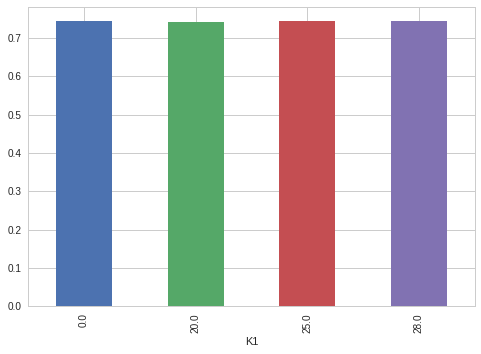

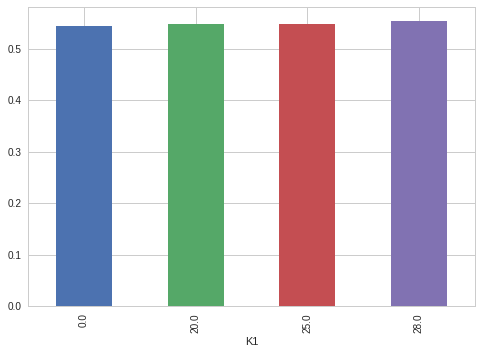

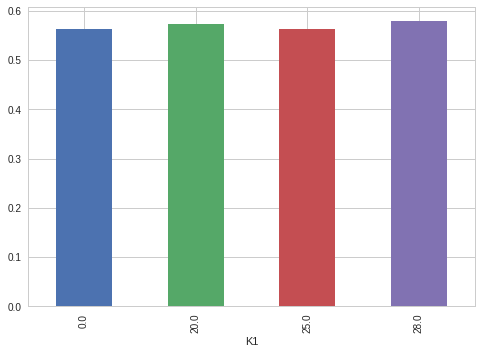

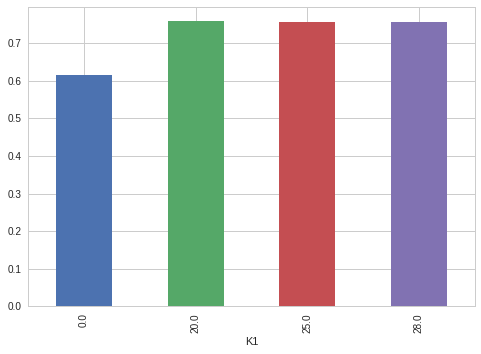

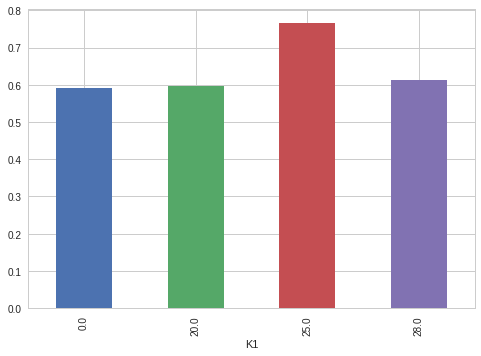

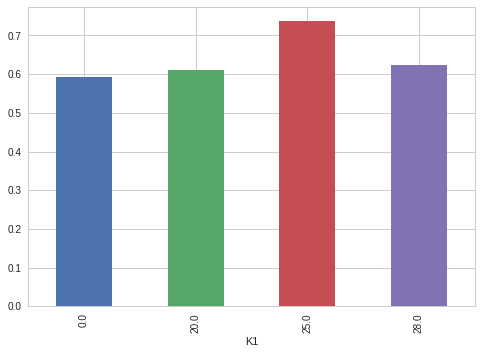

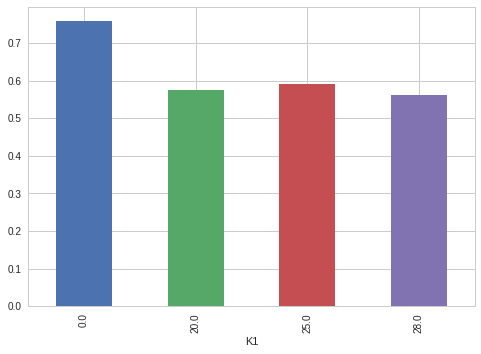

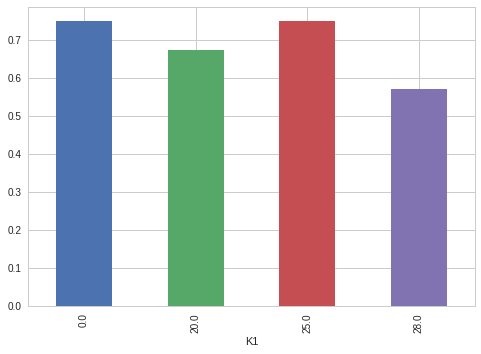

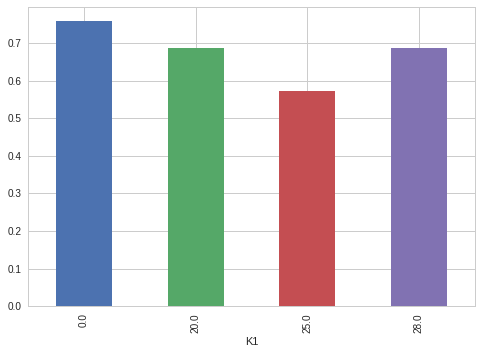

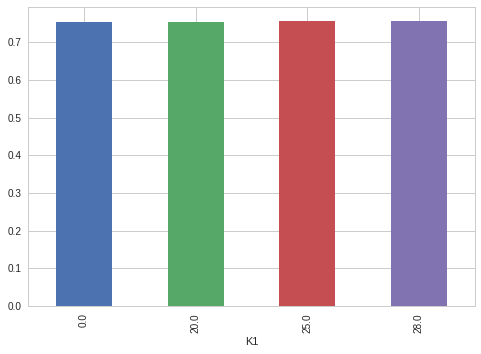

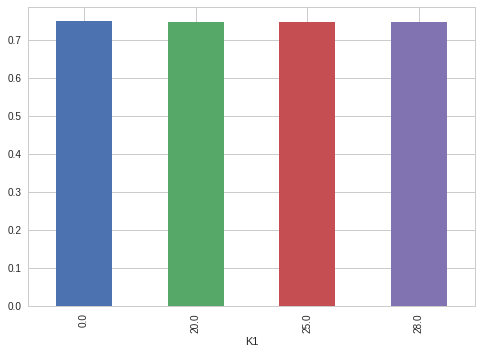

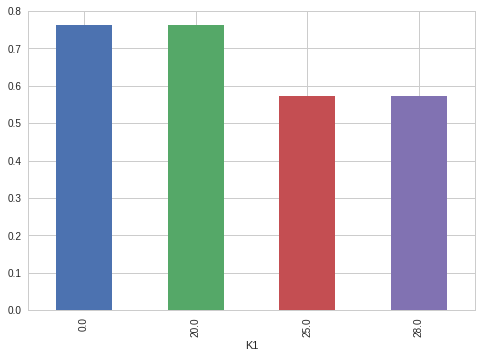

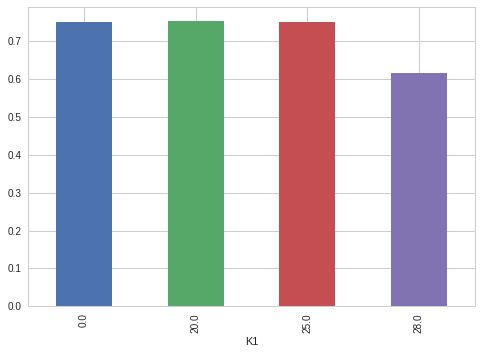

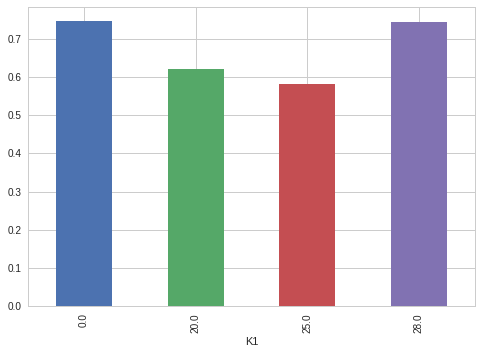

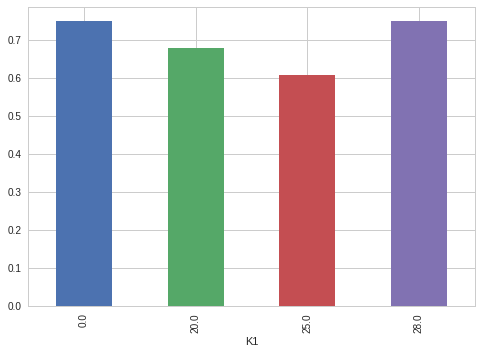

In [18]:
# for each stock I want to know the best results for each different r,s
##  df_res.sort_values(by='roc_cv', ascending=False).groupby(['stock', 'K1']).first()['roc_cv'].plot(kind='bar')
df_res = df_res.sort_values(by='roc_cv', ascending=False)
for s in stocks:
    if int(s) in list(df_res['stock']):
        df_res[df_res['stock'] == int(s)].groupby('K1').first()['roc_cv'].plot(kind='bar')
        plt.figure()

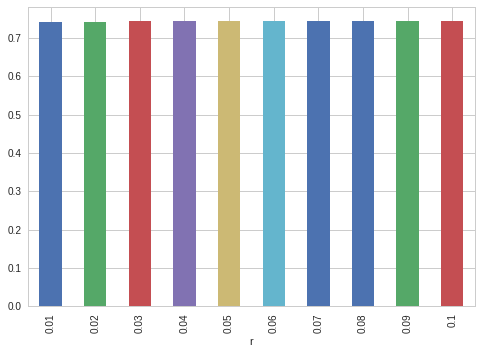

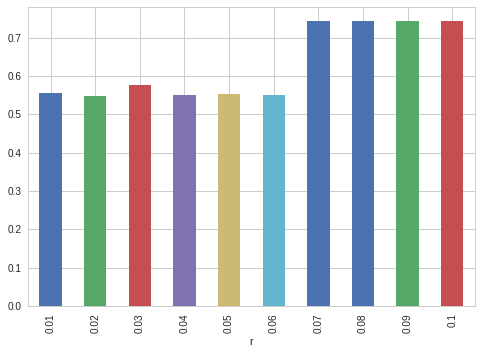

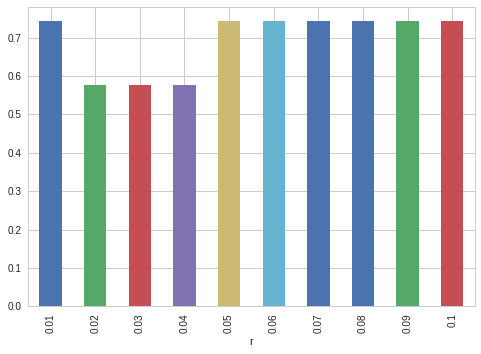

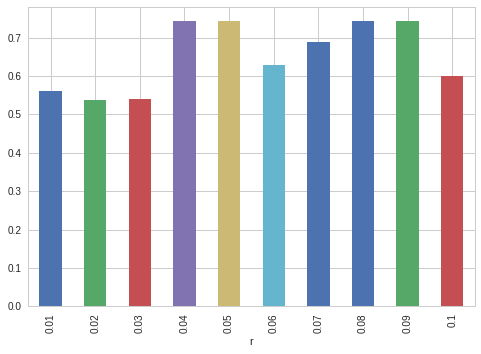

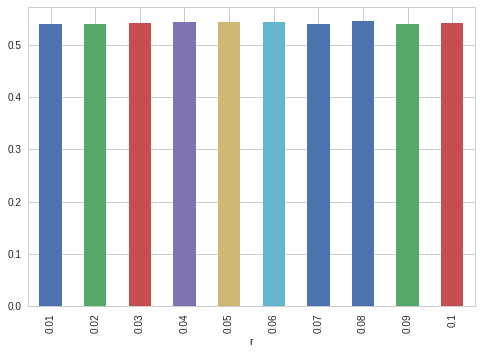

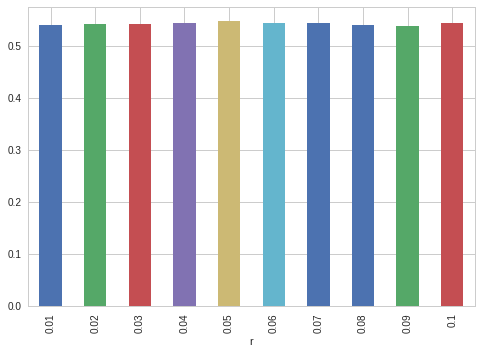

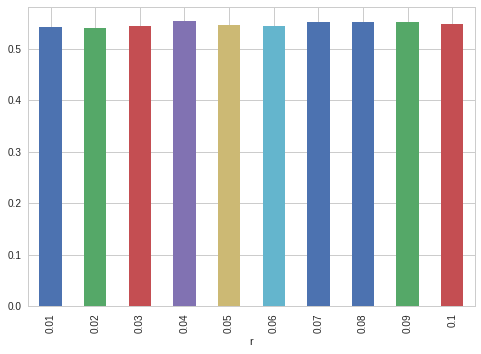

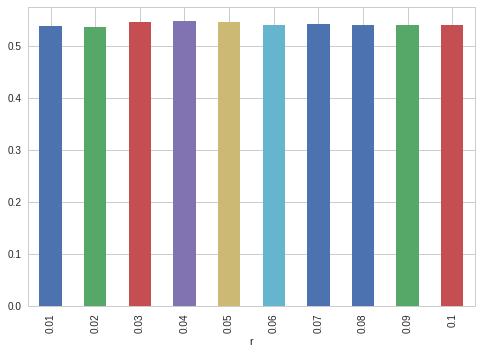

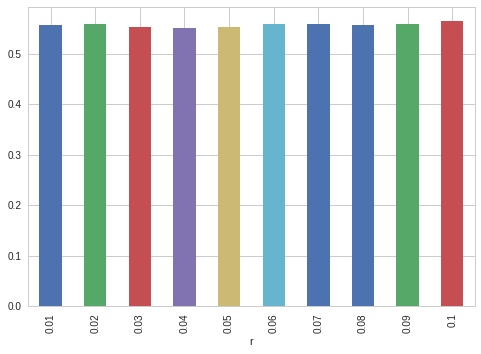

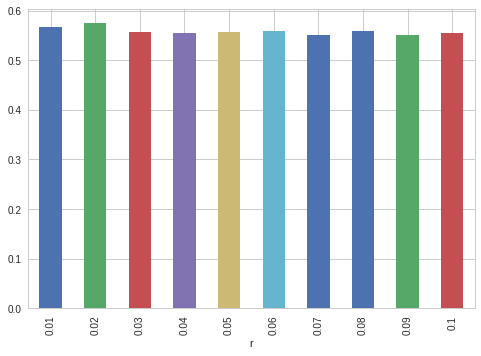

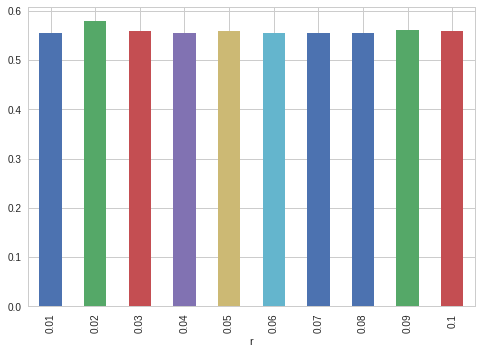

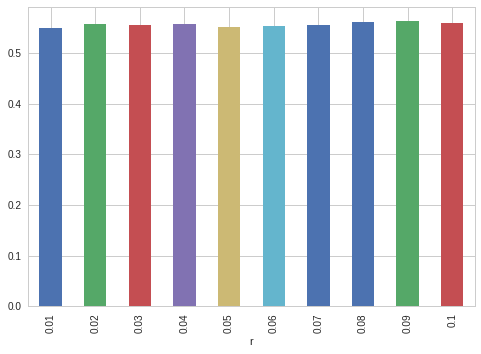

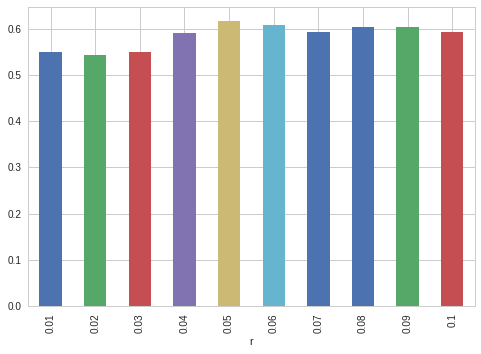

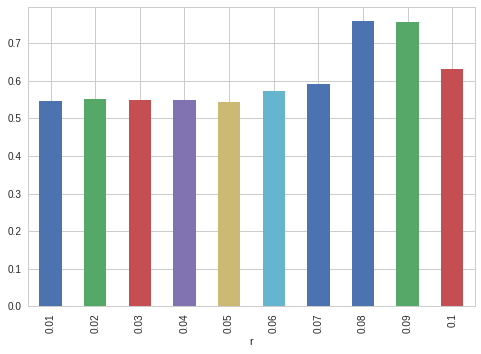

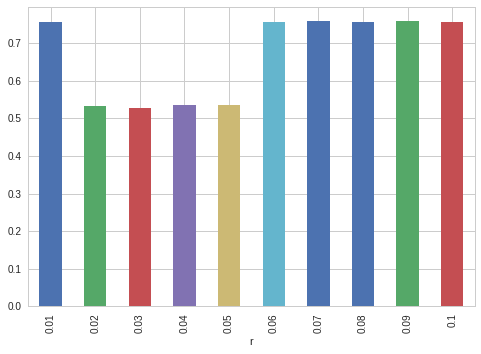

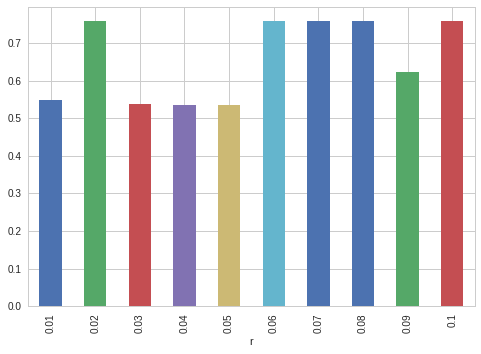

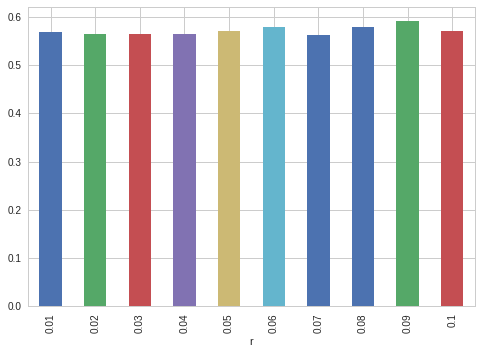

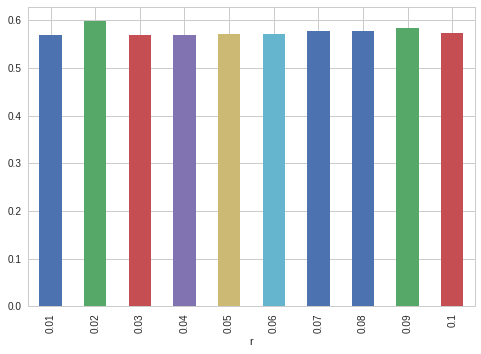

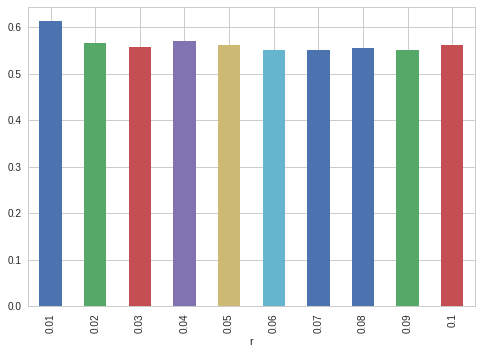

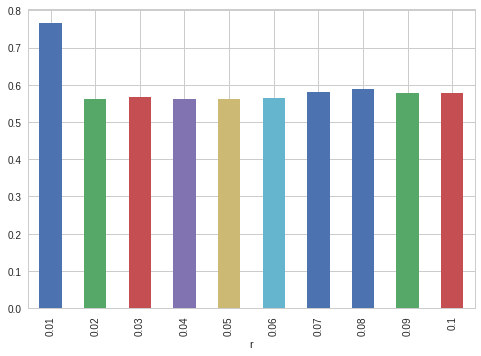

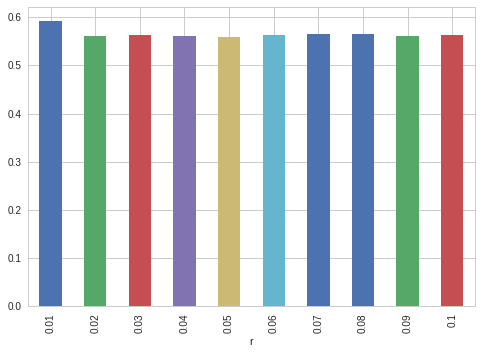

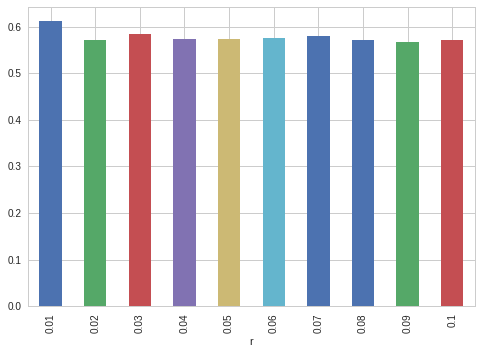

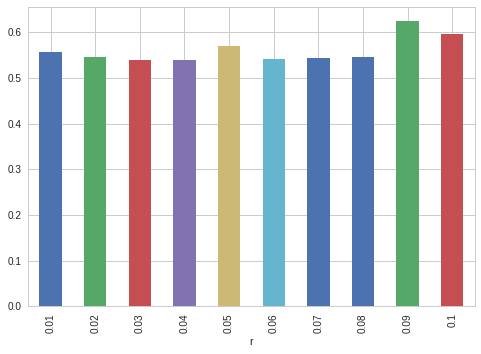

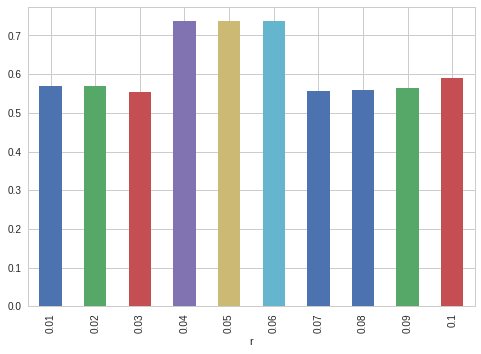

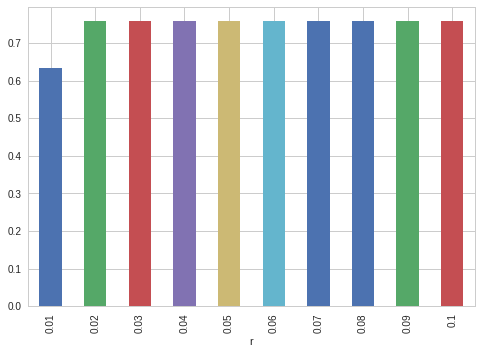

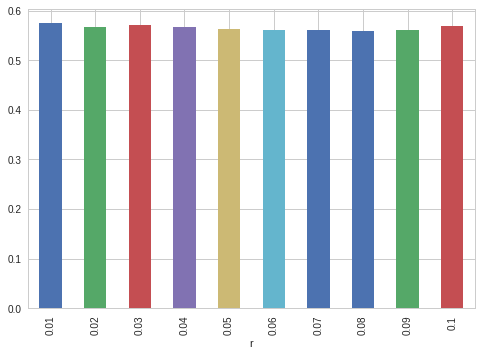

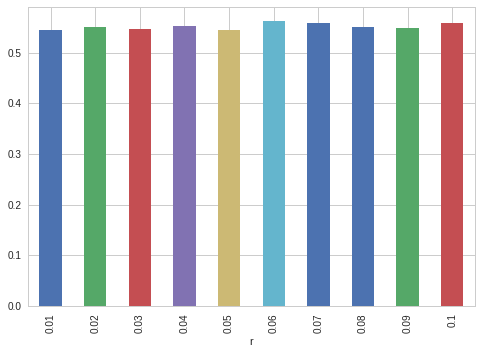

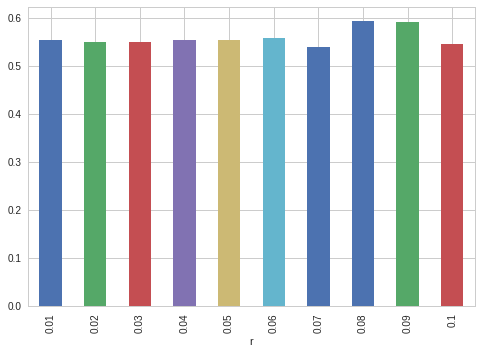

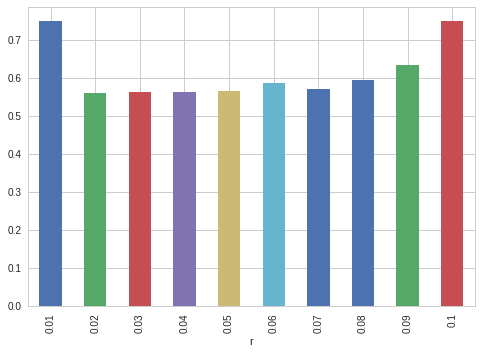

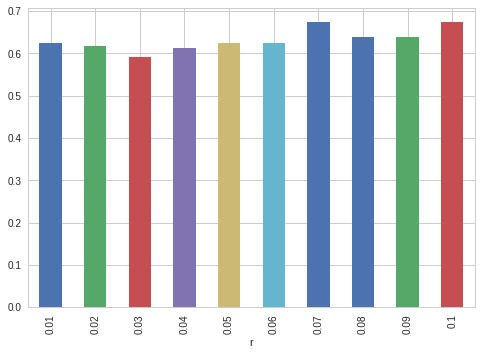

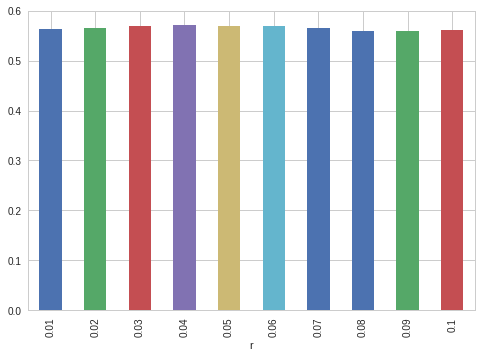

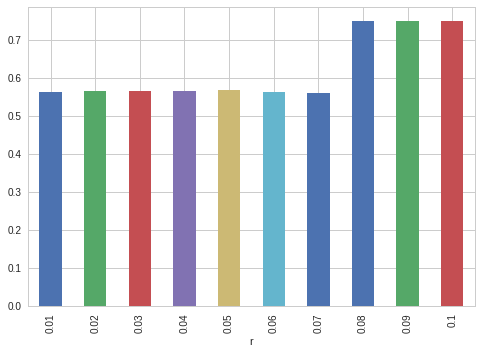

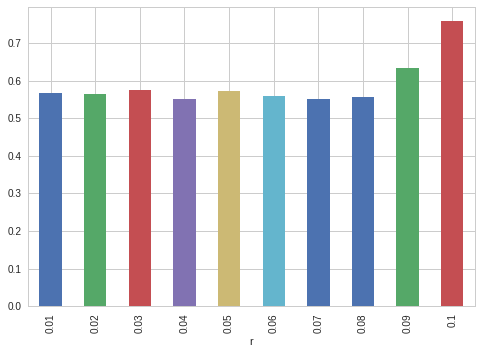

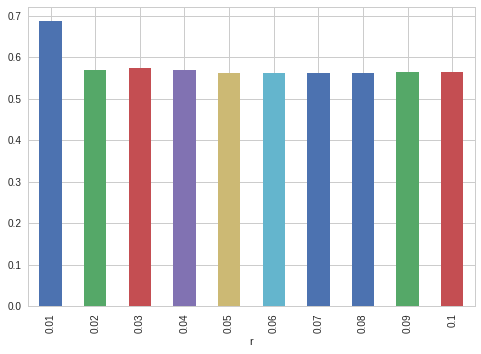

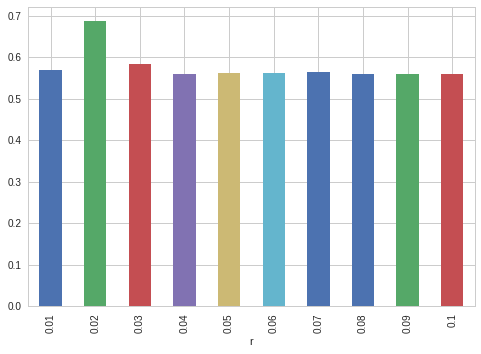

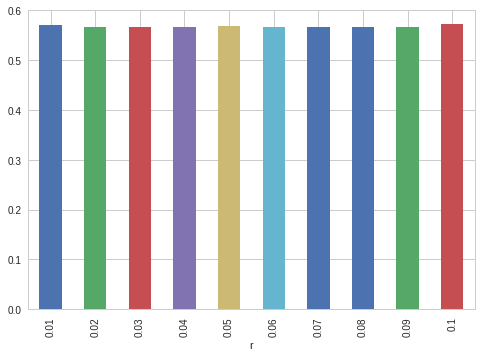

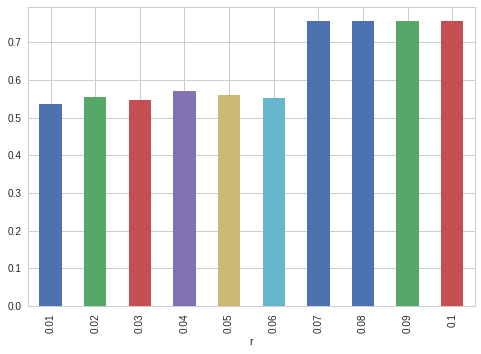

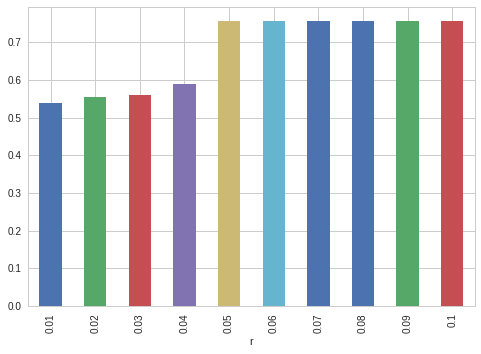

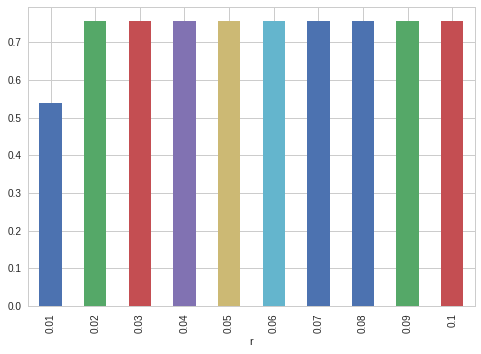

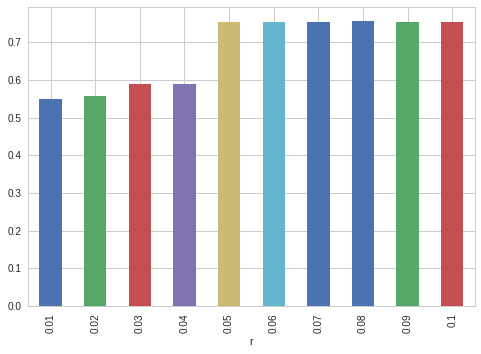

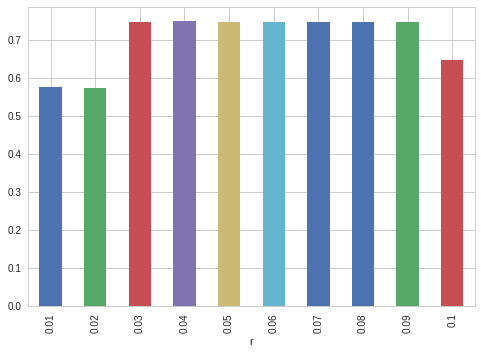

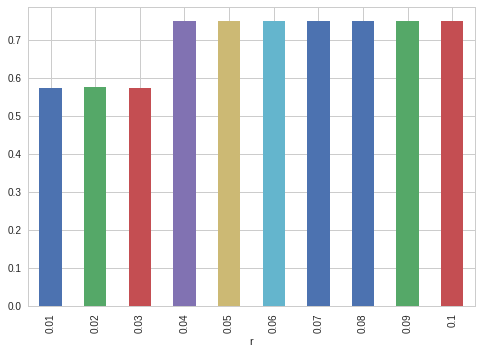

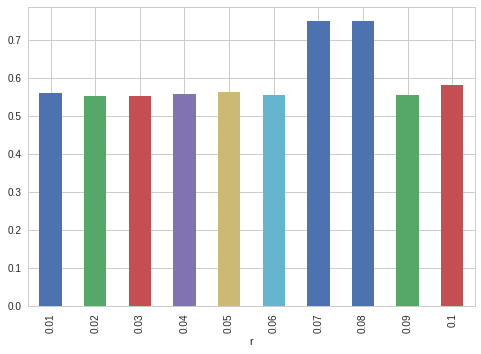

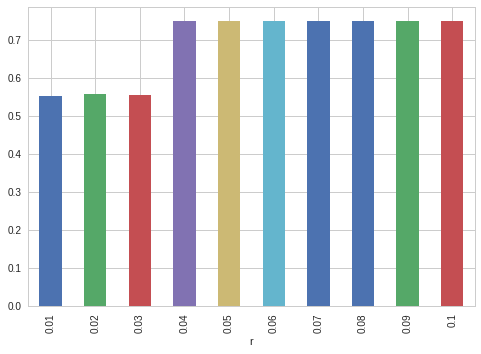

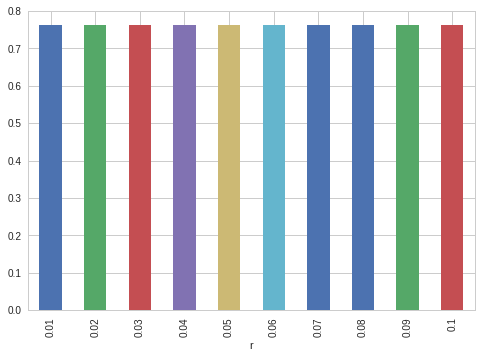

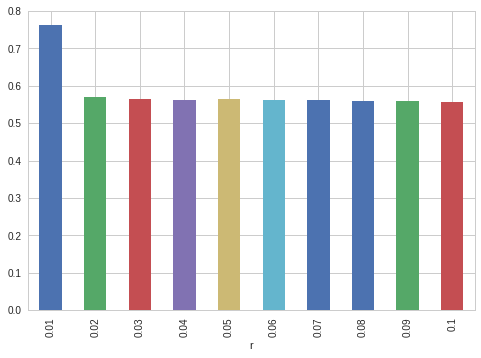

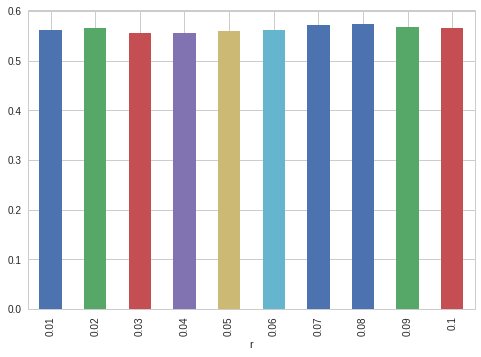

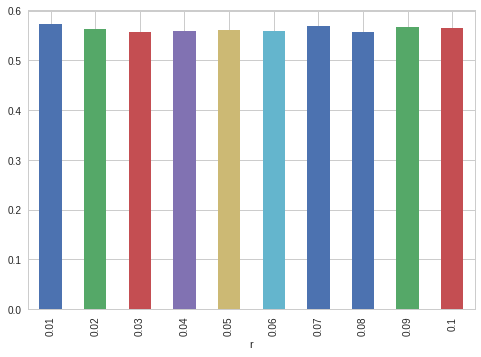

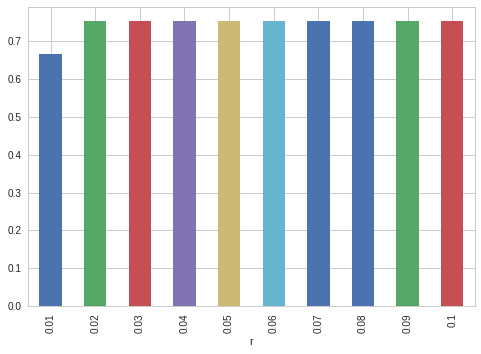

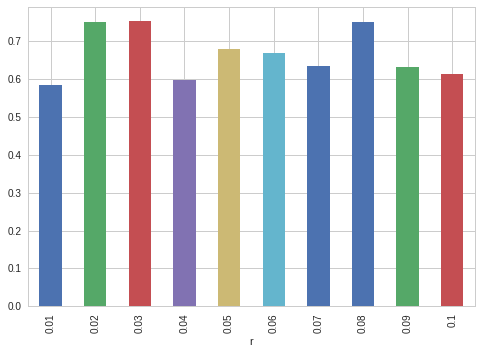

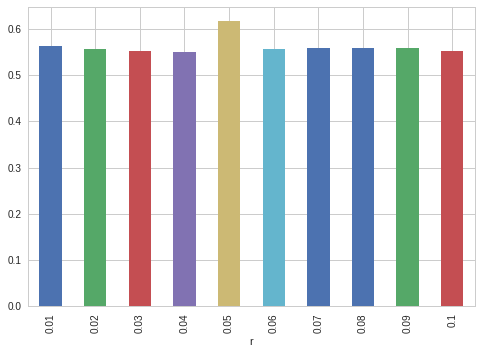

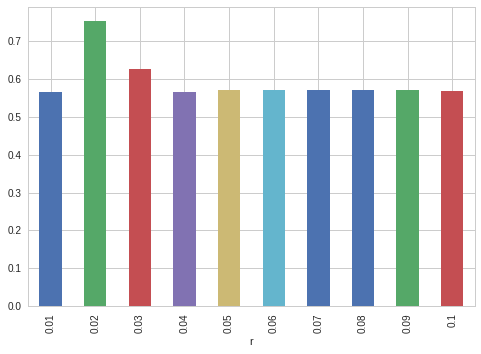

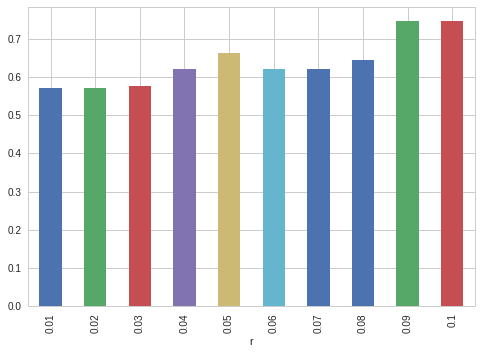

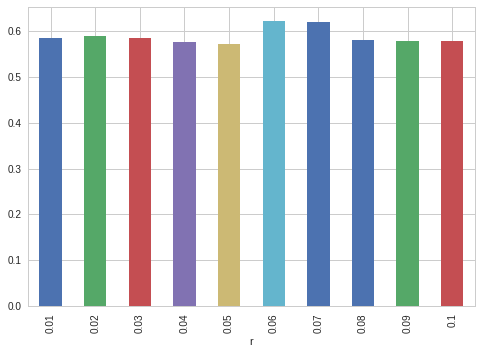

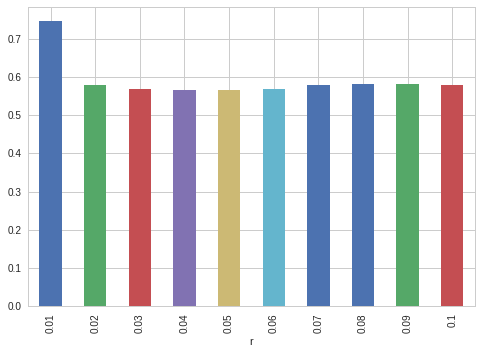

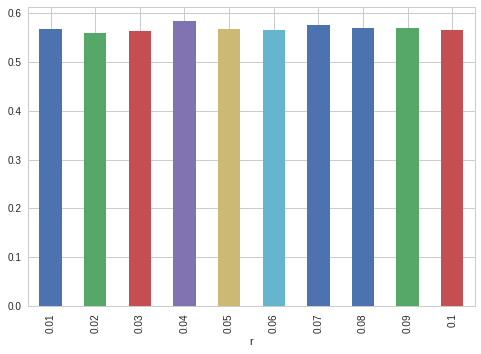

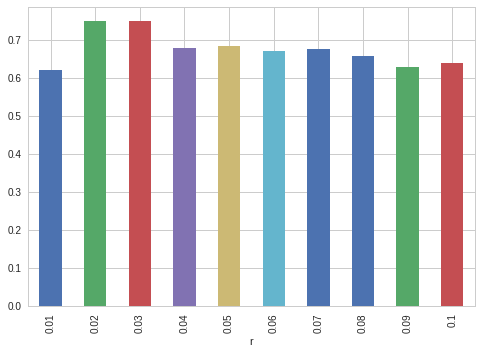

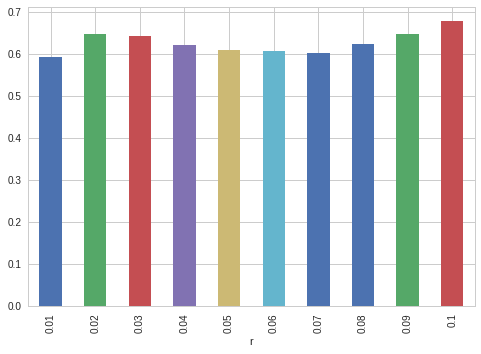

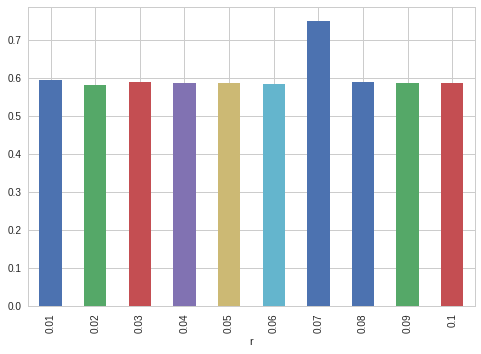

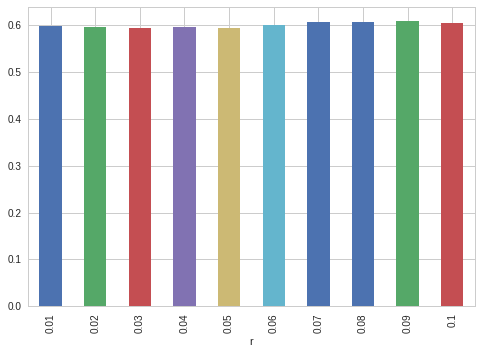

In [19]:
df_res = df_res.sort_values(by='roc_cv', ascending=False)
for s in stocks:
    for k in features_num:
        if int(s) in list(df_res['stock']):
            
            df_res[df_res['stock'] == int(s)][df_res['K1'] == k[0]].groupby(['r']).first()['roc_cv'].plot(kind='bar')
            plt.figure()

#### 9061

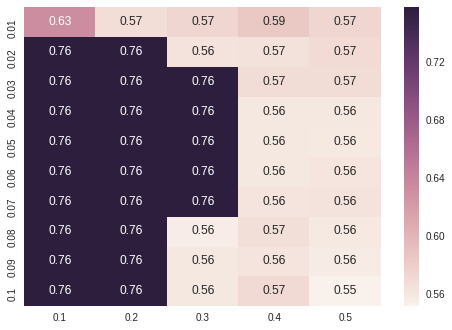

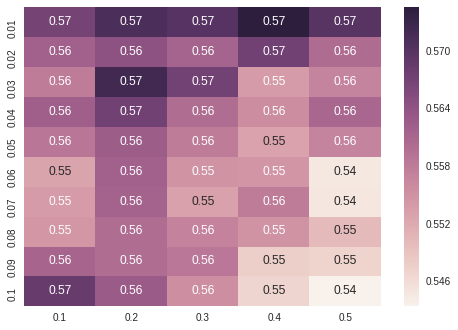

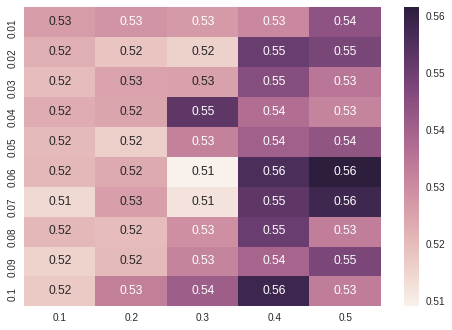

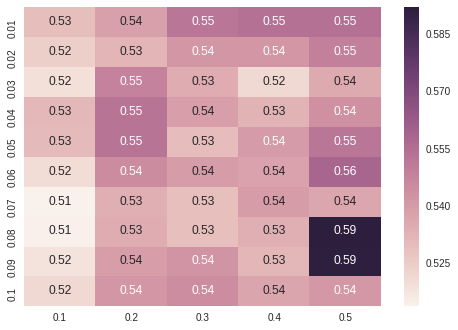

In [20]:
for kk in features_num:
    df_g = pd.DataFrame(index=rr, columns=ss)
    for i, row in df_res[df_res['stock'] == 12456][df_res['K1'] == kk[0]].groupby(['r', 's']).max().iterrows():
        if not np.isnan(row['roc_cv']):
            df_g.loc[i[0]][i[1]] = row['roc_cv']
    df_g = df_g.apply(pd.to_numeric)      
    sns.heatmap(df_g, annot=True)
    plt.figure()

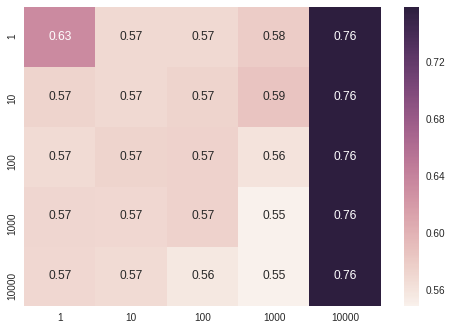

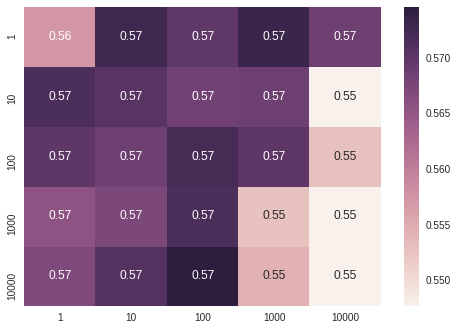

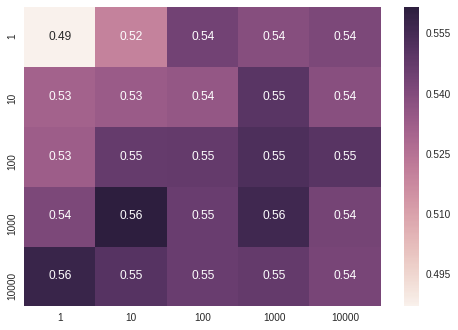

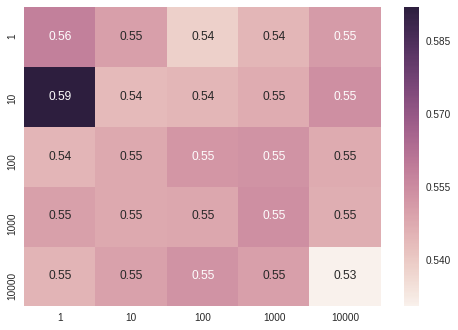

In [21]:
for kk in features_num:
    df_g = pd.DataFrame(index=sorted(df_res['C'].unique()), columns=sorted(df_res['gamma'].unique()))
    for i, row in df_res[df_res['stock'] == 12456][df_res['K1'] == kk[0]].groupby(['C', 'gamma']).max().iterrows():
        if not np.isnan(row['roc_cv']):
            df_g.loc[i[0]][i[1]] = row['roc_cv']
    df_g = df_g.apply(pd.to_numeric)      
    sns.heatmap(df_g, annot=True)
    plt.figure()

### All

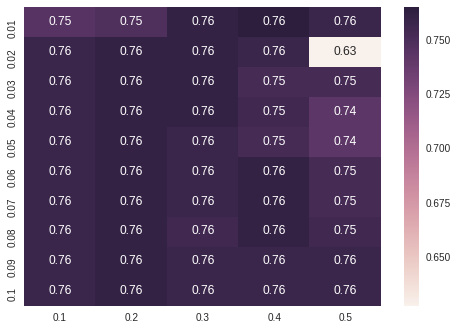

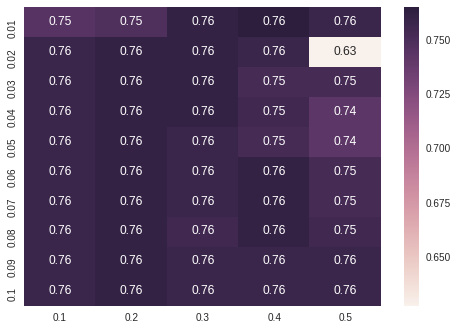

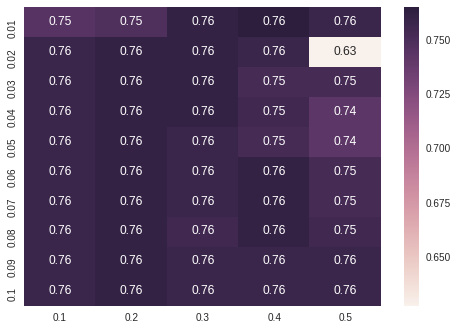

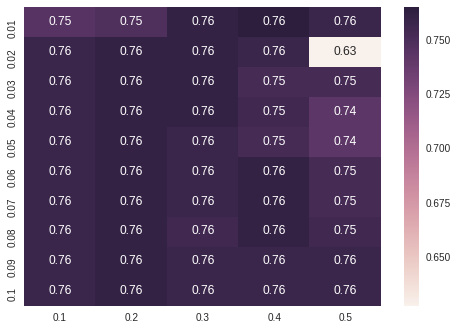

In [22]:
for kk in features_num:
    df_g = pd.DataFrame(index=rr, columns=ss)
    for i, row in df_res.groupby(['r', 's']).max().iterrows():
        if not np.isnan(row['roc_cv']):
            df_g.loc[i[0]][i[1]] = row['roc_cv']
    df_g = df_g.apply(pd.to_numeric)      
    sns.heatmap(df_g, annot=True)
    plt.figure()

### pairs k vs r,s

In [25]:
l = itertools.product(df_res['s'].unique().tolist(), df_res['r'].unique().tolist())
[str(i) for i in list(l)]

['(0.4, 0.01)',
 '(0.4, 0.02)',
 '(0.4, 0.08)',
 '(0.4, 0.06)',
 '(0.4, 0.07)',
 '(0.4, 0.1)',
 '(0.4, 0.04)',
 '(0.4, 0.03)',
 '(0.4, 0.09)',
 '(0.4, 0.05)',
 '(0.3, 0.01)',
 '(0.3, 0.02)',
 '(0.3, 0.08)',
 '(0.3, 0.06)',
 '(0.3, 0.07)',
 '(0.3, 0.1)',
 '(0.3, 0.04)',
 '(0.3, 0.03)',
 '(0.3, 0.09)',
 '(0.3, 0.05)',
 '(0.2, 0.01)',
 '(0.2, 0.02)',
 '(0.2, 0.08)',
 '(0.2, 0.06)',
 '(0.2, 0.07)',
 '(0.2, 0.1)',
 '(0.2, 0.04)',
 '(0.2, 0.03)',
 '(0.2, 0.09)',
 '(0.2, 0.05)',
 '(0.1, 0.01)',
 '(0.1, 0.02)',
 '(0.1, 0.08)',
 '(0.1, 0.06)',
 '(0.1, 0.07)',
 '(0.1, 0.1)',
 '(0.1, 0.04)',
 '(0.1, 0.03)',
 '(0.1, 0.09)',
 '(0.1, 0.05)',
 '(0.5, 0.01)',
 '(0.5, 0.02)',
 '(0.5, 0.08)',
 '(0.5, 0.06)',
 '(0.5, 0.07)',
 '(0.5, 0.1)',
 '(0.5, 0.04)',
 '(0.5, 0.03)',
 '(0.5, 0.09)',
 '(0.5, 0.05)']

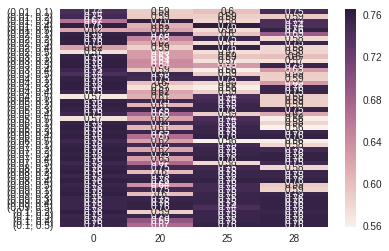

In [26]:
import itertools

l = itertools.product(df_res['s'].unique().tolist(), df_res['r'].unique().tolist())

df_g = pd.DataFrame(index=[str(i) for i in list(l)], columns=[0, 20, 25, 28])
for i, row in df_res.groupby(['K1', 'r', 's']).max().iterrows():
    if not np.isnan(row['roc_cv']):

        df_g.loc[str((i[1],i[2])), i[0]] = row['roc_cv']
df_g = df_g.apply(pd.to_numeric)      
sns.heatmap(df_g.iloc[50:100], annot=True)
plt.figure()

In [27]:
df_g = pd.DataFrame(index=[list(l)], columns=[0, 20, 25, 28])
df_g

,0,20,25,28
